### 1. 提取MNIST数据

In [10]:
import numpy as np

def read_idx_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_items = int.from_bytes(f.read(4), 'big'), int.from_bytes(f.read(4), 'big')
        if magic != 2049:  # Magic number for the MNIST label file
            raise ValueError("File is not a valid MNIST label file.")

        # Read the labels
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels


def read_idx_images(filename):
    with open(filename, 'rb') as f:
        # Read the magic number
        magic = int.from_bytes(f.read(4), 'big')
        if magic != 2051:  # Magic number for the MNIST image file
            raise ValueError("File is not a valid MNIST image file.")

        # Read dimensions: number of images, rows, and columns
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')

        # Read the data
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)
        return data

(60000, 28, 28)


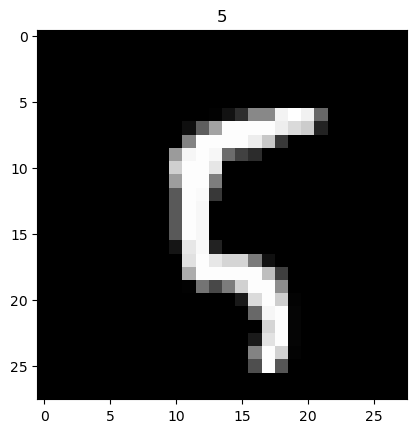

In [11]:
import matplotlib.pyplot as plt

images_train = read_idx_images('MNIST_ORG/train-images.idx3-ubyte')
labels_train = read_idx_labels('MNIST_ORG/train-labels.idx1-ubyte')

images_test = read_idx_images('MNIST_ORG/t10k-images.idx3-ubyte')
labels_test = read_idx_labels('MNIST_ORG/t10k-labels.idx1-ubyte')

print(images_train.shape)
print(labels_train.shape)


In [ ]:
plt.imshow(images_train[100], cmap='gray')
plt.title(labels_train[100])
plt.show()

### 2.数据预处理

我们需要对数据预处理。归一化图像数据以及对标签进行one-hot编码。

In [12]:
from tensorflow.keras.utils import to_categorical

# 归一化图像数据
images_train = images_train.astype('float32') / 255
images_test = images_test.astype('float32') / 255

# 将标签转换为 one-hot 编码
labels_train = to_categorical(labels_train, 10)
labels_test = to_categorical(labels_test, 10)


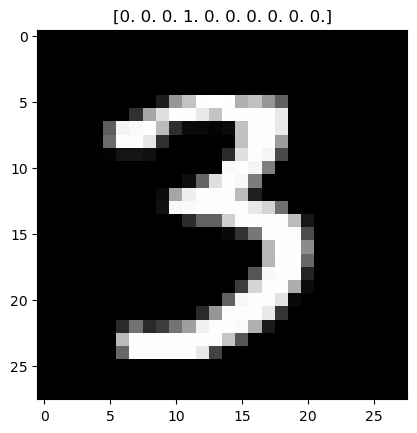

In [13]:
import matplotlib.pyplot as plt
plt.imshow(images_train[10000], cmap='gray')
plt.title(labels_train[10000])
plt.show()

### 3.构建模型

使用Keras构建一个简单的卷积神经网络：

In [14]:
import tensorflow as tf


model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(64, activation='relu', kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=-2.0, max_value=2.0)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=-2.0, max_value=2.0)),
  tf.keras.layers.Activation('softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


现在模型已经构建好了，我们来训练它。

In [16]:
model.fit(images_train, labels_train, epochs=10, batch_size=64, validation_data=(images_test, labels_test))

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.4255 - accuracy: 0.8776 - val_loss: 0.2020 - val_accuracy: 0.9416
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2291 - accuracy: 0.9343 - val_loss: 0.1644 - val_accuracy: 0.9539
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1936 - accuracy: 0.9439 - val_loss: 0.1437 - val_accuracy: 0.9588
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1789 - accuracy: 0.9486 - val_loss: 0.1383 - val_accuracy: 0.9606
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1704 - accuracy: 0.9516 - val_loss: 0.1303 - val_accuracy: 0.9640
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1626 - accuracy: 0.9544 - val_loss: 0.1293 - val_accuracy: 0.9626
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1606 - accuracy: 0.9559 - val_loss: 0.1296 - val_accuracy: 0.9647
Epoch 

使用验证集测试准确度

In [17]:
test_loss, test_acc = model.evaluate(images_test, labels_test, verbose=2)
print('\nTest accuracy:', test_acc)


313/313 - 0s - loss: 0.1228 - accuracy: 0.9658 - 334ms/epoch - 1ms/step

Test accuracy: 0.9657999873161316


保存整个模型

In [18]:
model.save('model/mnist.h5')
model.save_weights('model/mnist_weights.h5')

### 4.转换TFLite

转换为TensorFlow Lite格式

In [20]:
import tensorflow as tf
 
 
model = tf.keras.models.load_model('model/mnist.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
 
# 开启动态量化
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("model/mnist_quantized_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Q\AppData\Local\Temp\tmpvf2stsez\assets


55128